In [72]:
# import libs 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 

from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

In [73]:
#####################
# 1. Gathering Data #
#####################

def get_data():
    #get train data
    train_data_path ='c:/DOM/train.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='c:/DOM/test.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.Price
  train.drop(['Price'],axis = 1 , inplace = True)

  combined = train.append(test)
  combined.drop(['ListingID','DOM','Date'], inplace=True, axis=1)
  return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()
#Combine train and test data to process them together
combined, target = get_combined_data()

#Describe the data
combined.describe()


,ApartmentCount,Bath,Bed,FloorCount,Latitude,Longitude,Price,TotalRooms,YearBuilt,Zip
count,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,6500.000000,32362.000000,32362.000000,32362.000000
mean,125.587757,1.349855,1.418500,14.515172,40.737478,-73.975400,4406.596615,4.016544,1947.864749,10385.426859
std,186.070250,0.645980,1.011572,13.875059,0.043300,0.024367,4512.504265,5.906200,44.436048,545.189866
min,0.000000,-2.000000,0.000000,0.000000,40.574998,-74.146534,750.000000,0.500000,1790.000000,10001.000000
25%,10.000000,1.000000,1.000000,5.000000,40.706306,-73.992214,2395.000000,3.000000,1910.000000,10014.000000
50%,60.000000,1.000000,1.000000,9.000000,40.740036,-73.979028,3100.000000,3.000000,1931.000000,10025.000000
75%,173.000000,2.000000,2.000000,19.000000,40.771444,-73.960139,4556.250000,4.000000,1991.000000,11201.000000
max,8756.000000,8.000000,7.000000,90.000000,41.024034,-73.748864,70000.000000,99.000000,2018.000000,11694.000000


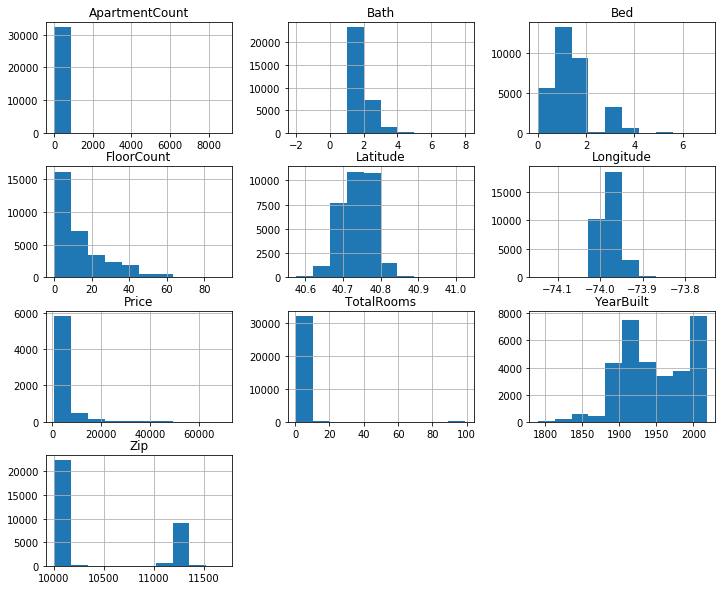

In [74]:
# Histograms
# They help to visualize the distribution of the variables
# We can use it in order to detect OUTLIERS (see TotalRooms)
combined.hist(figsize = (12,10))
plt.show()

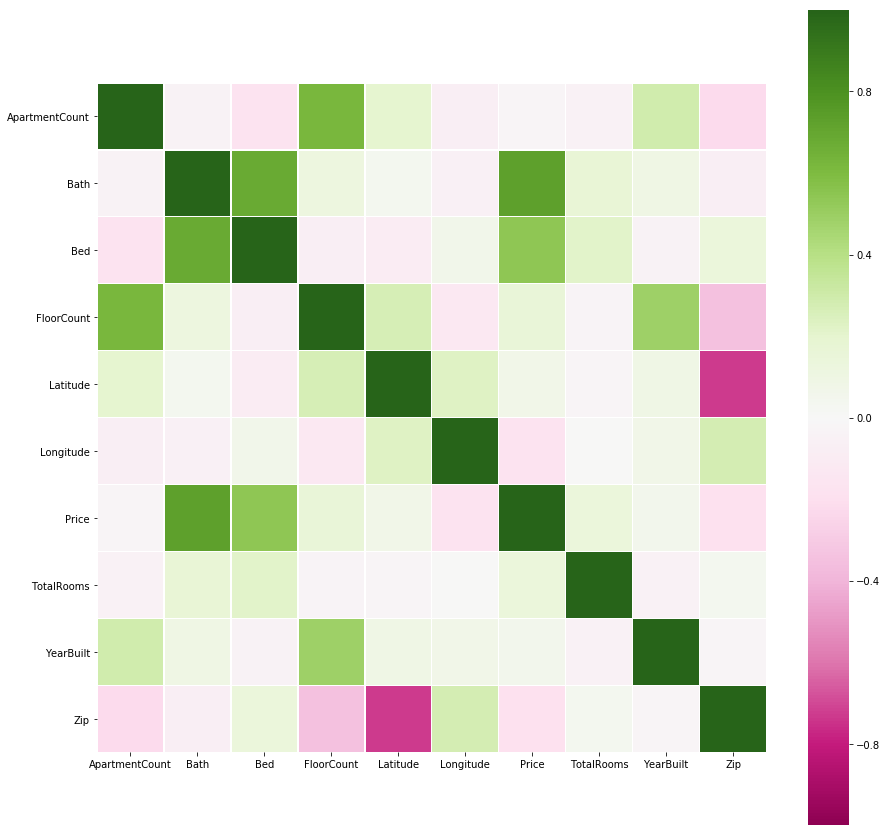

In [75]:
# Correlation Matrix
# This helps to understand very quickly the correlation among variables
# Here we can see that BATHS highly correlated with Price

C_mat = combined.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = 1, vmin=-1, square = True, cmap="PiYG", linewidths=.5)
plt.show()

In [76]:
##########################
# 2. Preparing that data #
##########################
# We transform categorical variables into dummy variables 
# For example we transform variable Neighborhood into a set of dummy variables: 
# Neighborhood_FortGreene = 0 / 1, Neighborhood_MidtownEast = 0 / 1,...

def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

combined = combined[num_cols + cat_cols]

#print ('Number of numerical columns with no nan values :',len(num_cols))
#print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

#print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

combined.describe()


,ApartmentCount,Bath,Bed,FloorCount,Latitude,Longitude,TotalRooms,YearBuilt,Zip,Class_Apartment Building,...,Neighborhood_Williamsburg,Neighborhood_Windsor Terrace,Neighborhood_Woodside,Type_Co-op,Type_Condo,Type_Condop,Type_Mixed Use Townhouse,Type_Multi Family Townhouse,Type_New Development Condo,Type_Single Family Townhouse
count,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,...,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000,32362.000000
mean,125.587757,1.349855,1.418500,14.515172,40.737478,-73.975400,4.016544,1947.864749,10385.426859,0.758915,...,0.037235,0.004728,0.000464,0.169365,0.412923,0.016130,0.013658,0.319850,0.060194,0.007880
std,186.070250,0.645980,1.011572,13.875059,0.043300,0.024367,5.906200,44.436048,545.189866,0.427749,...,0.189340,0.068597,0.021525,0.375080,0.492367,0.125978,0.116068,0.466426,0.237850,0.088418
min,0.000000,-2.000000,0.000000,0.000000,40.574998,-74.146534,0.500000,1790.000000,10001.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,1.000000,5.000000,40.706306,-73.992214,3.000000,1910.000000,10014.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,60.000000,1.000000,1.000000,9.000000,40.740036,-73.979028,3.000000,1931.000000,10025.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,173.000000,2.000000,2.000000,19.000000,40.771444,-73.960139,4.000000,1991.000000,11201.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,8756.000000,8.000000,7.000000,90.000000,41.024034,-73.748864,99.000000,2018.000000,11694.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
######################
# 3. Chosing a model #
######################
# We need to create a model capable of predicting a CONTINUOUS variable PRICE.
# We'll use different algorithms (Decision Tree, Random Forest and XGBoost) to create different models and see how they perform.

###############
# 4. Training #
###############

#Split back to train / test (the prepared data set with dummy variables)
def split_combined():
    global combined
    train = combined[:25862]
    test = combined[25862:]

    return train , test 

train, test = split_combined()

# We define the models Decision Tree, Random Forest and XGBoost
# We will use the parameter "max_depth=4" (max_depth could be taken as a measure of the complexity of the model)
# Do not worry! We will come back later to discuss this!

# DecisionTree(Regressor) 
DTModel = DecisionTreeRegressor(max_depth=4)  
DTModel.fit(train, target) 

#RandomForest
RFModel = RandomForestRegressor(max_depth=4)
RFModel.fit(train,target)

#XGB
XGBModel = XGBRegressor(max_depth=4)
XGBModel.fit(train, target)

print ("Models are trained!")

Models are trained!


In [78]:
#################
# 5. Evaluation #
#################
# We ask the models to predict test data
# We compare observed data (real price) versus predicted price and calculate the MAE for each model

# Eval DecicionTree
DTpredictions = DTModel.predict(test)
MAE = mean_absolute_error(test_data.Price , DTpredictions)
print('Decision Tree validation MAE = ', MAE)

# Eval RandomForest
RFpredictions = RFModel.predict(test)
MAE = mean_absolute_error(test_data.Price , RFpredictions)
print('Random Forest validation MAE = ', MAE)

# Eval XGBoost
XGBpredictions = XGBModel.predict(test)
MAE = mean_absolute_error(test_data.Price , XGBpredictions)
print('XGBoost validation MAE = ',MAE)


Decision Tree validation MAE =  1276.3691736654264
Random Forest validation MAE =  1219.90133031098
XGBoost validation MAE =  924.9871056002104


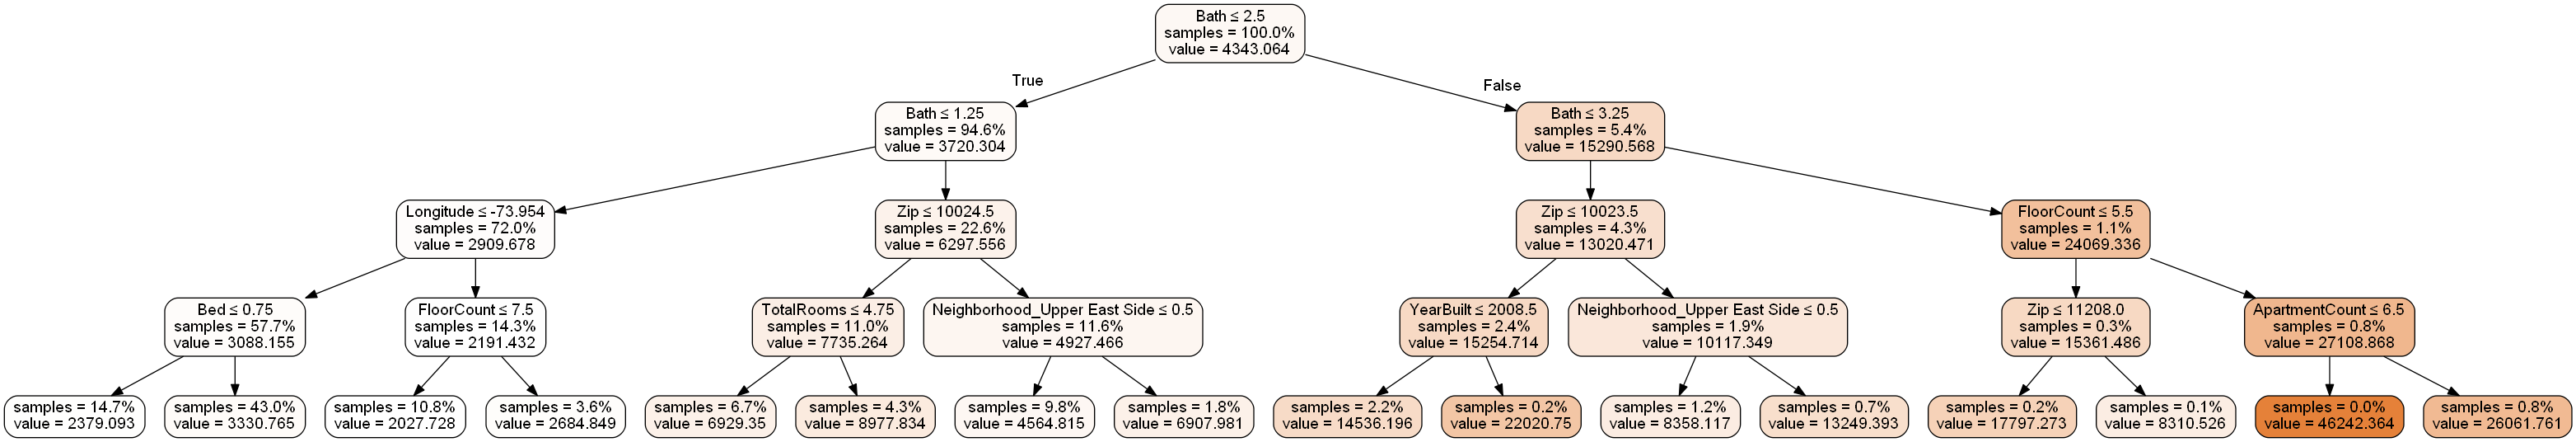

In [79]:
# Let's take a look into the decision tree model
# This is just to give you an idea how a model looks like
# Random forest and XGBoost are more complicated to visualize as they are a combination of trees

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/ariel.novelli/release/bin/'

#import graphviz
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz

from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(DTModel, out_file=dot_data,
                feature_names=combined.columns,
                filled=True, rounded=True,
                special_characters=True,
                proportion=True,
                impurity=False
               )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
# Zoom into the model and explain how it is created
# Go back to the PPT and discuss about the complexity of a model


In [80]:
#############
# 6. Tuning #
#############
# I defined a new model using XGBoost with max_depth=12
# Max possible complexity to get the best possible mae for testing data

#Train XGBoost with max_depth=12
XGBModel = XGBRegressor(max_depth=12)
XGBModel.fit(train, target, verbose=False)

# Eval New XGBoost (Train)
XGBpredictions = XGBModel.predict(train)
MAE = mean_absolute_error(train_data.Price , XGBpredictions)
print('XGBoost validation MAE (Train) = ',MAE)

#from sklearn.metrics import r2_score
#print (r2_score(train_data.Price, XGBpredictions))

# Eval New XGBoost (Test)
XGBpredictions = XGBModel.predict(test)
MAE = mean_absolute_error(test_data.Price , XGBpredictions)
print('XGBoost validation MAE (TEST) = ',MAE)

#from sklearn.metrics import r2_score
#print (r2_score(test_data.Price, XGBpredictions))

XGBoost validation MAE (Train) =  382.0611722623285
XGBoost validation MAE (TEST) =  709.0042270413912


In [81]:
#################
# 7. Prediction #
#################

# I create a function in order to write a csv file with model predictions
# I define the structure of the file as: ListingId, ListingPrice (Observed), Predicted (Model Prediction)
def make_prediction(prediction, sub_name):
    my_submission = pd.DataFrame({'ListingID':pd.read_csv('c:/DOM/test.csv').ListingID,'ListingPrice':pd.read_csv('c:/DOM/test.csv').Price,'Predicted':prediction})
    my_submission.to_csv('{}.csv'.format(sub_name),index=False)
    print('Prediction file has been generated!')


make_prediction(XGBpredictions,'XGBModel_Prediction.csv')


Prediction file has been generated!


In [ ]:
# Open the CSV and show how to calculate MAE with Excel
# Go back to the PPT for the last slides

